In [1]:
# Import necessary libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## **2.1** Loading the Image

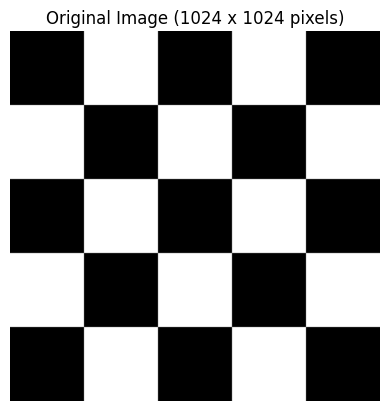

In [2]:
# Load the image
image_path = 'checkerboard.png'
image = Image.open(image_path).convert('L')
image_array = np.array(image)

plt.imshow(image, cmap='gray')
plt.title('Original Image (1024 x 1024 pixels)')	
plt.axis('off')
plt.show()

## **2.2** Histogram & Cumulative Probability Function

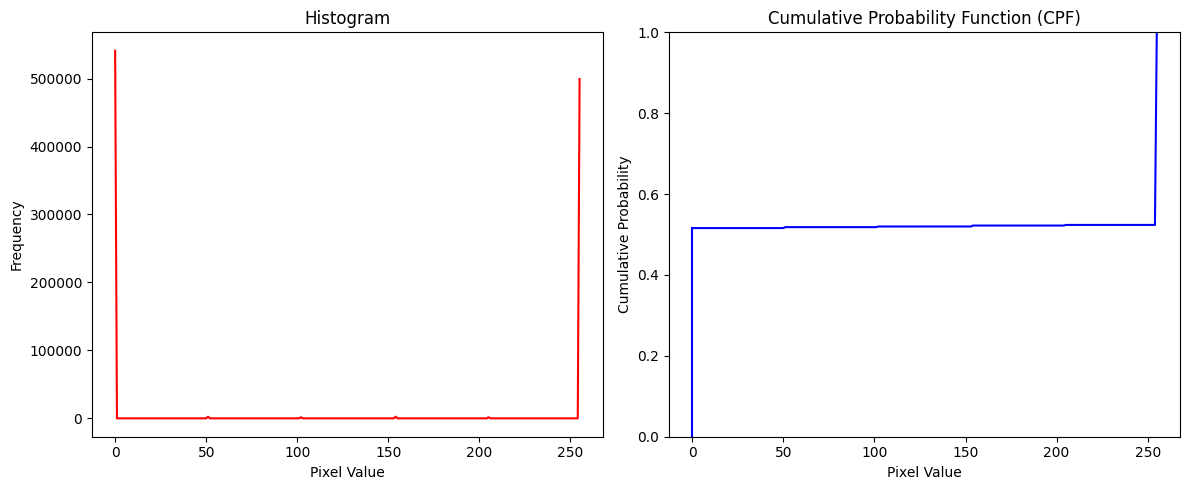

In [3]:
# Compute histogram
hist, bins = np.histogram(image_array, bins=256, range=(0, 255))

# Compute cumulative probability function (CPF)
cpf = np.cumsum(hist) / np.sum(hist)

# Plot histogram and CPF 
plt.figure(figsize=(12, 5))

# Histogram plot
plt.subplot(1, 2, 1)
plt.plot(hist, color='red')
plt.title('Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# CPF plot
plt.subplot(1, 2, 2)
plt.plot(cpf, color='blue')
plt.plot([0, bins[0]], [0, cpf[0]], color='blue', linestyle='-')
plt.title('Cumulative Probability Function (CPF)')
plt.xlabel('Pixel Value')
plt.ylabel('Cumulative Probability')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## **2.3** Low-Pass Filter in the Spatial Domain

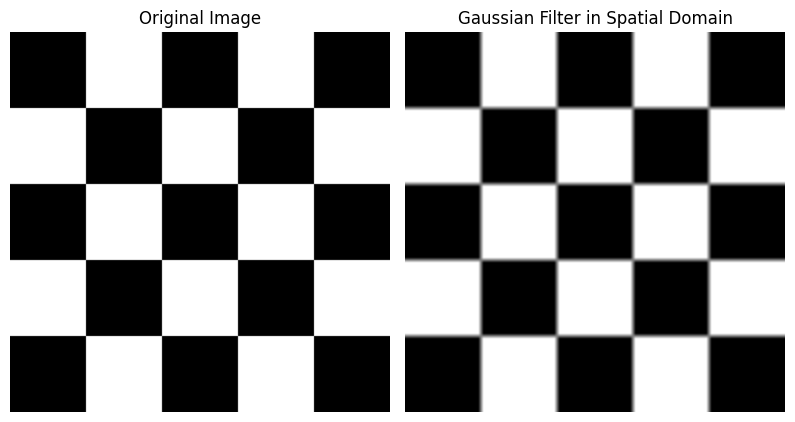

In [4]:
def gaussian_filter(image_array, kernel_size, sigma):
    # Create a Gaussian kernel
    k = kernel_size // 2
    y, x = np.ogrid[-k:k+1, -k:k+1]
    
    # Create the Gaussian kernel
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # Normalize the kernel so it sums to 1
    kernel = kernel / kernel.sum()
    
    # Get image dimensions
    height, width = image_array.shape
    # Initialize the output image
    blurred_image = np.zeros_like(image_array)
    
    # Apply the Gaussian filter (convolution)
    padded_image = np.pad(image_array, k, mode='edge')  # Pad with edge values
    
    for i in range(height):
        for j in range(width):
            # Extract the region of interest
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            # Convolve (element-wise multiplication and sum)
            blurred_image[i, j] = np.sum(region * kernel)
    
    return blurred_image

# Apply the Gaussian blur 
gaussian_spatial = gaussian_filter(image_array, 15, 9)

# Plot the original and smoothed images side by side
plt.figure(figsize=(12, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Gaussian blur result
plt.subplot(1, 3, 2)
plt.imshow(gaussian_spatial, cmap='gray')
plt.title('Gaussian Filter in Spatial Domain')
plt.axis('off')

plt.tight_layout()
plt.show()

## **2.4** Explain if the low-pass filter you selected is separable

The gaussian filter used is seperable. A filter is seperable when it can be written as a product of two or more simpler filter. In this example, a 2D gaussian filter is given by: 
$w(i, j) = Ke ^{-\frac{i^2 + j^2}{2σ^2}}$

This can be repreented into two 1D filters, one for each direction, given by:
$Ke ^{-\frac{i^2}{2σ^2}}$ and $Ke ^{-\frac{j^2}{2σ^2}}$

This means that the two 1D filters can be applied along the rows and columns as opposed to applying a 2D filter in an area of an image.  This reduces the computational cost, where applying a 2D filter on a $M \cdot N$ image will give a time complexity of $O(M \cdot N \cdot m \cdot n)$, which is reduced to $O(M \cdot N \cdot (m + n))$

## **2.5** Low-Pass Filter in the Frequency Domain

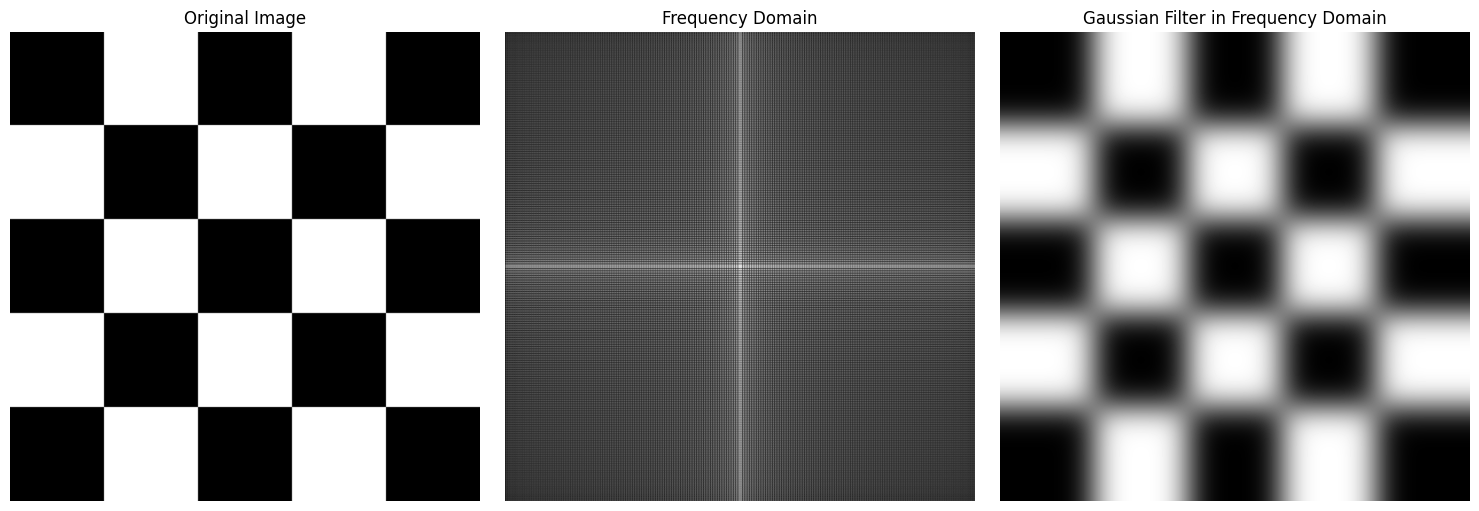

In [5]:
# Perform 2D FFT to transform the image to the frequency domain
fft_image = np.fft.fft2(image_array)
fft_shifted = np.fft.fftshift(fft_image)

def gaussian_low_pass(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    x, y = np.ogrid[:rows, :cols]
    
    # Calculate the distance from the center
    distance = np.sqrt((x - crow)**2 + (y - ccol)**2)
    
    # Create a Gaussian mask
    mask = np.exp(-(distance**2) / (2 * (cutoff**2)))
    return mask

# Apply the Gaussian low-pass filter
mask = gaussian_low_pass(image_array.shape, 5)
filtered_fft = fft_shifted * mask

# Transform back to the spatial domain
ifft_shifted = np.fft.ifftshift(filtered_fft)
gaussian_freq = np.fft.ifft2(ifft_shifted)
gaussian_freq = np.abs(gaussian_freq)  # Take the magnitude

# Display the frequency domain image (magnitude spectrum)
magnitude_spectrum = np.log1p(np.abs(fft_shifted))

# Plot the original, frequency domain, and smoothed images side by side
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Frequency domain image
plt.subplot(1, 3, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Frequency Domain')
plt.axis('off')

# Smoothed image (frequency domain filtering)
plt.subplot(1, 3, 3)
plt.imshow(gaussian_freq, cmap='gray')
plt.title('Gaussian Filter in Frequency Domain')
plt.axis('off')

plt.tight_layout()
plt.show()


## **2.6** Low-Pass Filter Histogram

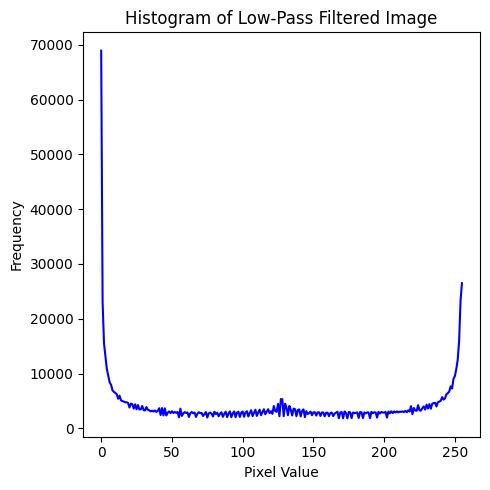

In [6]:
# Compute the histogram of the low-pass filtered image in the frequency domain
hist, _ = np.histogram(gaussian_freq, bins=256, range=(0, 255))

# Plot the histogram for the frequency domain
plt.figure(figsize=(5, 5))
plt.plot(hist, color='blue')
plt.title('Histogram of Low-Pass Filtered Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## **2.7** Uniform Probability

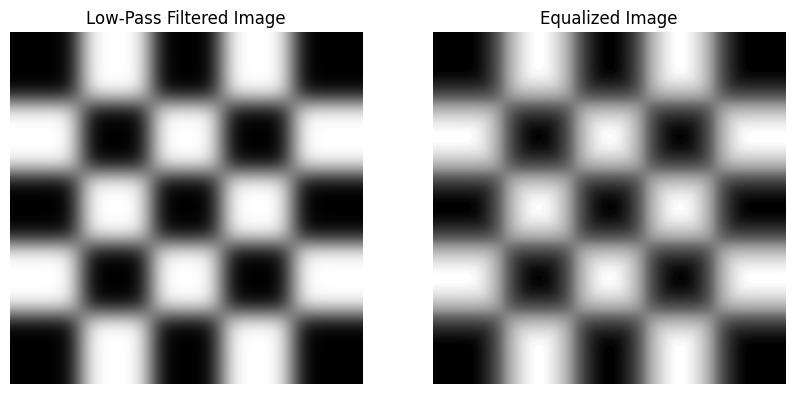

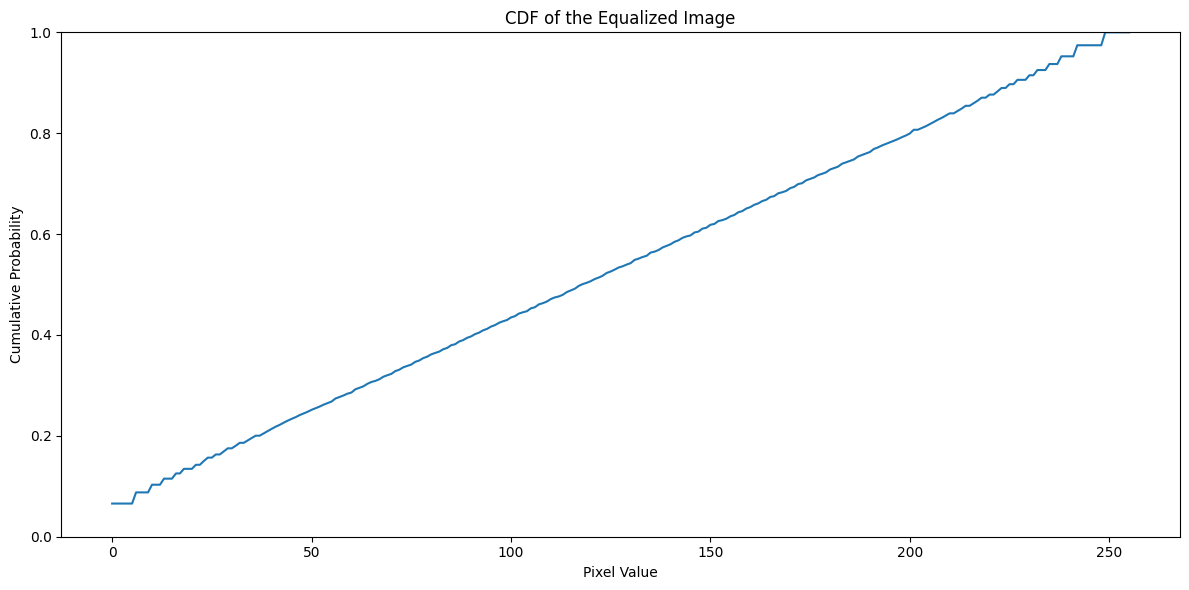

In [14]:
# Flatten the image and calculate the histogram
hist, _ = np.histogram(gaussian_freq.flatten(), bins=256, range=(0, 255))

# Compute the cumulative distribution function (CDF)
cdf = hist.cumsum()
cdf_normalized = (cdf - cdf.min()) / (cdf.max() - cdf.min()) * 255  # Normalize to [0, 255]

# Ensure the image values are integers for indexing
gaussian_freq_int = gaussian_freq.astype(np.uint8)

# Apply the mapping to the original image
equalized_image = cdf_normalized[gaussian_freq_int]

# Compute the histogram of the equalized image
hist_eq, _ = np.histogram(equalized_image.flatten(), bins=256, range=(0, 255))

# Compute the cumulative distribution function (CDF) of the equalized image
equalized_cdf = np.cumsum(hist_eq) / equalized_image.size

# Plot the equalized image
plt.figure(figsize=(10, 5))

# Low-pass filtered image
plt.subplot(1, 2, 1)
plt.imshow(gaussian_freq, cmap='gray')
plt.title('Low-Pass Filtered Image')
plt.axis('off')

# Equalized image
plt.subplot(1, 2, 2)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.plot(range(256), equalized_cdf)
plt.title('CDF of the Equalized Image')
plt.xlabel('Pixel Value')
plt.ylabel('Cumulative Probability')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()